In [1]:
!pip install -qq transformers

     |████████████████████████████████| 1.9MB 5.2MB/s 
     |████████████████████████████████| 890kB 21.2MB/s 
     |████████████████████████████████| 3.2MB 28.0MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%ls

dataset.gdoc  meme_analysis/  MultiOFF_Dataset-20200906T073117Z-001.zip


In [8]:
%cd   drive

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/bert_sentiment_analysis/internet_meme


In [9]:
%cd MyDrive/bert_sentiment_analysis/internet_meme/

[Errno 2] No such file or directory: 'MyDrive/bert_sentiment_analysis/internet_meme/'
/content/drive/MyDrive/bert_sentiment_analysis/internet_meme


In [10]:
%cd meme_analysis/


/content/drive/My Drive/bert_sentiment_analysis/internet_meme/meme_analysis


In [1]:
#Import required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc


import transformers
from transformers import BertModel, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');
print(device)

cpu


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [5]:
df = pd.read_csv("meme_img_des_caption_210310.csv")

In [6]:
def to_sentiment(sentiment):
  if sentiment == 'Non-offensiv':
    return 1
  else:
    return 0

In [7]:
def con_img_des_img_cap(img_des):
    return img_des

In [8]:
df['Sentiment'] = df.Sentiment.apply(to_sentiment)
print(df.Sentiment)

0      1
1      0
2      1
3      0
4      1
      ..
715    1
716    0
717    1
718    1
719    0
Name: Sentiment, Length: 720, dtype: int64


In [9]:
df['text'] = '[CLS]'+df.Image_text.apply(con_img_des_img_cap) + '[SEP]'+ df.image_caption.apply(con_img_des_img_cap)+ '[SEP]'
print(df.text)

0      [CLS]IREFUSETO DEBATTEMY PRIMARYOPPONENTBECAUS...
1      [CLS]Max @ mdlabick BERNIE SANDERS RALLY 2016-...
2      [CLS]Bernie is Red Free College Tuition WAKE M...
3      [CLS]The fuck Bernie Sanders ' starter pack TH...
4      [CLS]THIS SUNDAY BECAUSE CONFLIMEMEZ I LOVE CL...
                             ...                        
715    [CLS]My rural neighbor is a hippie Bernie supp...
716    [CLS]Anonymous ( ID : mHMIfKBM ) 06/24/16 ( Fr...
717    [CLS]bern png 48 KB , 733x594 ) google igdb An...
718    [CLS]When Trump purchased and rebuilt Mar-A-La...
719    [CLS]at This is horrifying ! Share this to spr...
Name: text, Length: 720, dtype: object


In [10]:
class_names = ['negative', 'positive']
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
MAX_LEN = 160

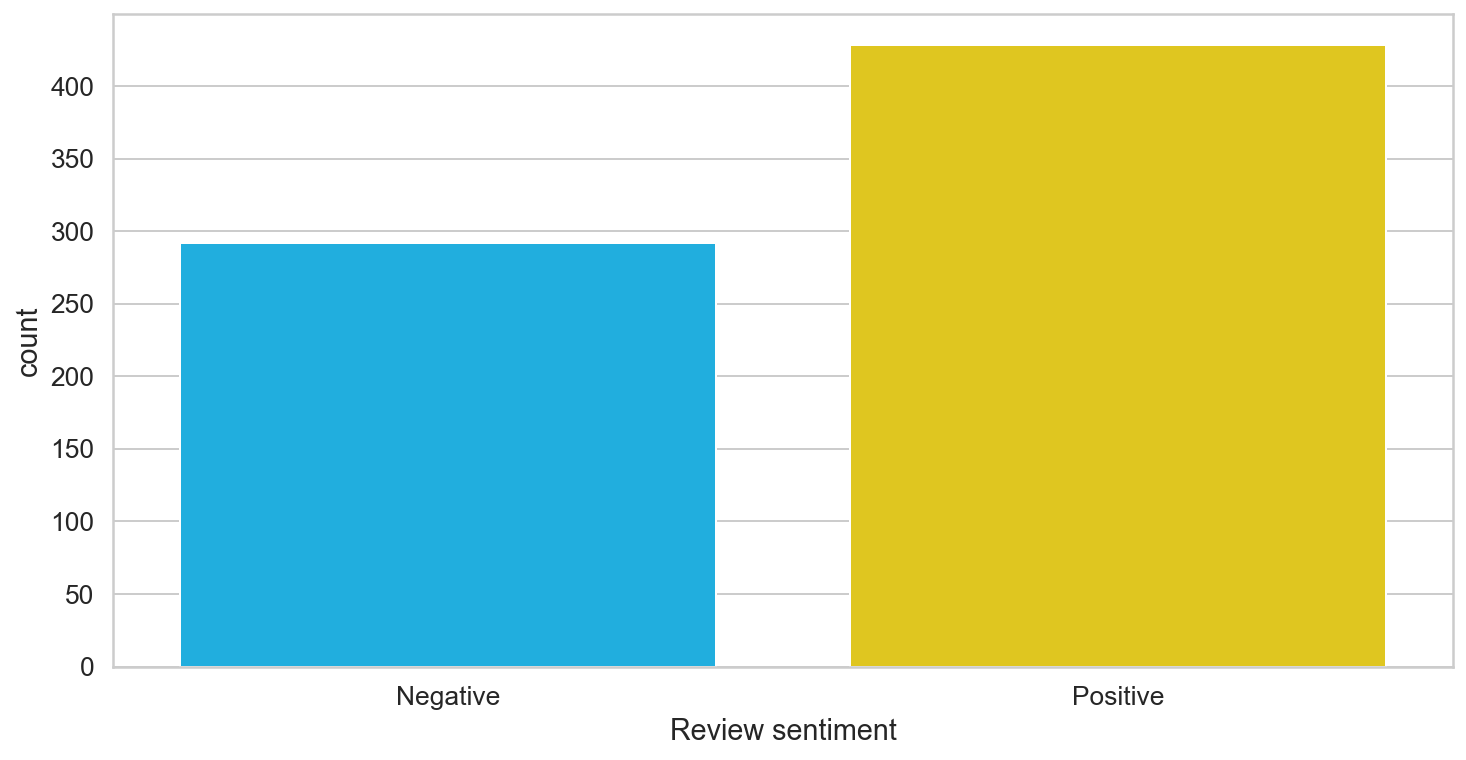

In [11]:
ax=sns.countplot(df.Sentiment)
plt.xlabel('Review sentiment')
class_names=['Negative','Positive']
ax.set_xticklabels(class_names)
plt.show()

In [12]:
class MemeDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [39]:
df_train, df_test = train_test_split(df, test_size=0.95, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.05,random_state=RANDOM_SEED)
print(len(df_train), len(df_test), len(df_val))

36 35 649


In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MemeDataset(
    reviews=df.text.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [41]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [42]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [43]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [31]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [32]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [33]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    print(outputs.shape)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model, 'model_210312.bin')
    # torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
torch.Size([32, 160])
torch.Size([32, 2])
torch.Size([32, 160])


KeyboardInterrupt: 

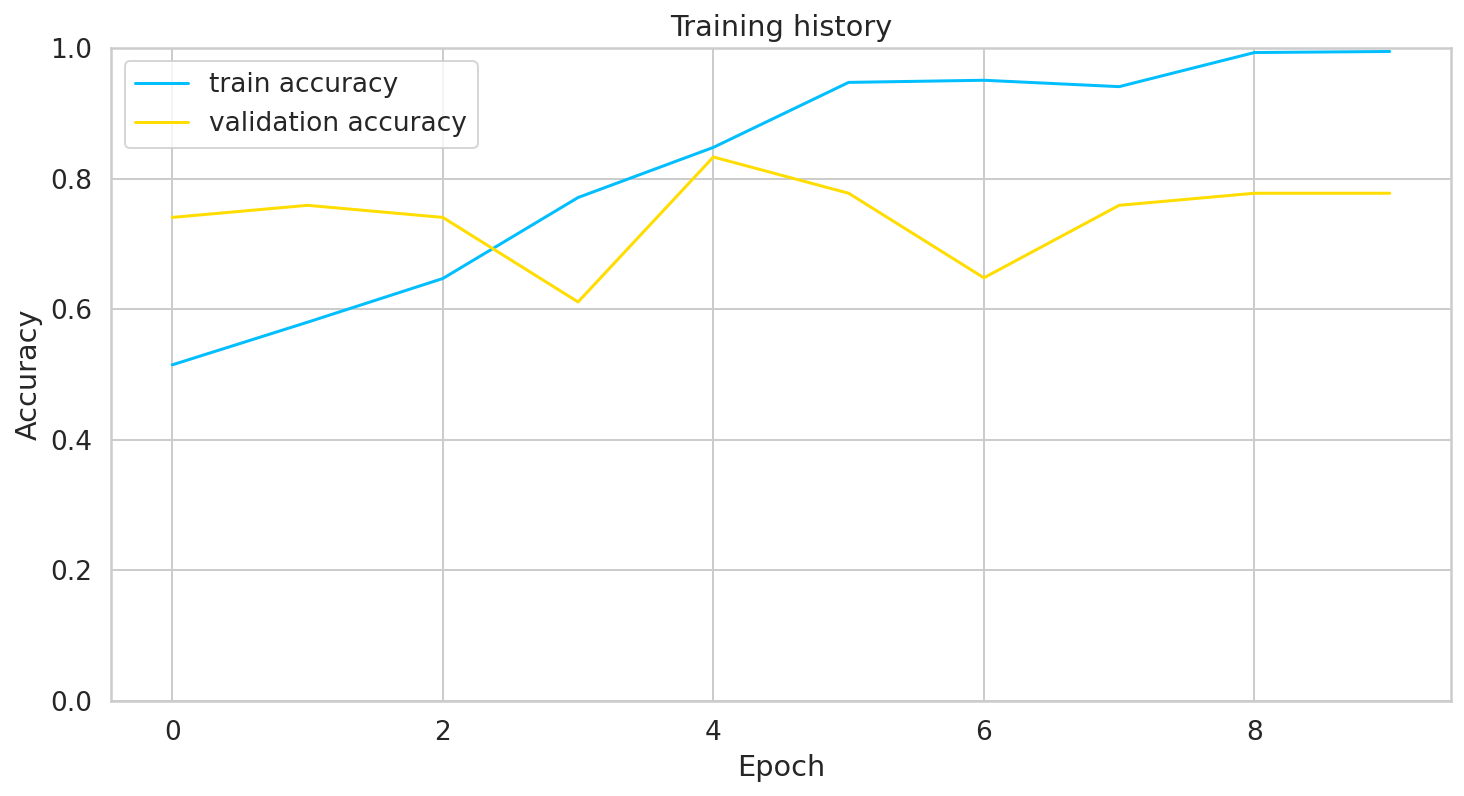

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_report=classification_report(y_test, y_pred, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

    Negative       0.72      0.52      0.60        25
    Positive       0.67      0.83      0.74        29

    accuracy                           0.69        54
   macro avg       0.69      0.67      0.67        54
weighted avg       0.69      0.69      0.68        54



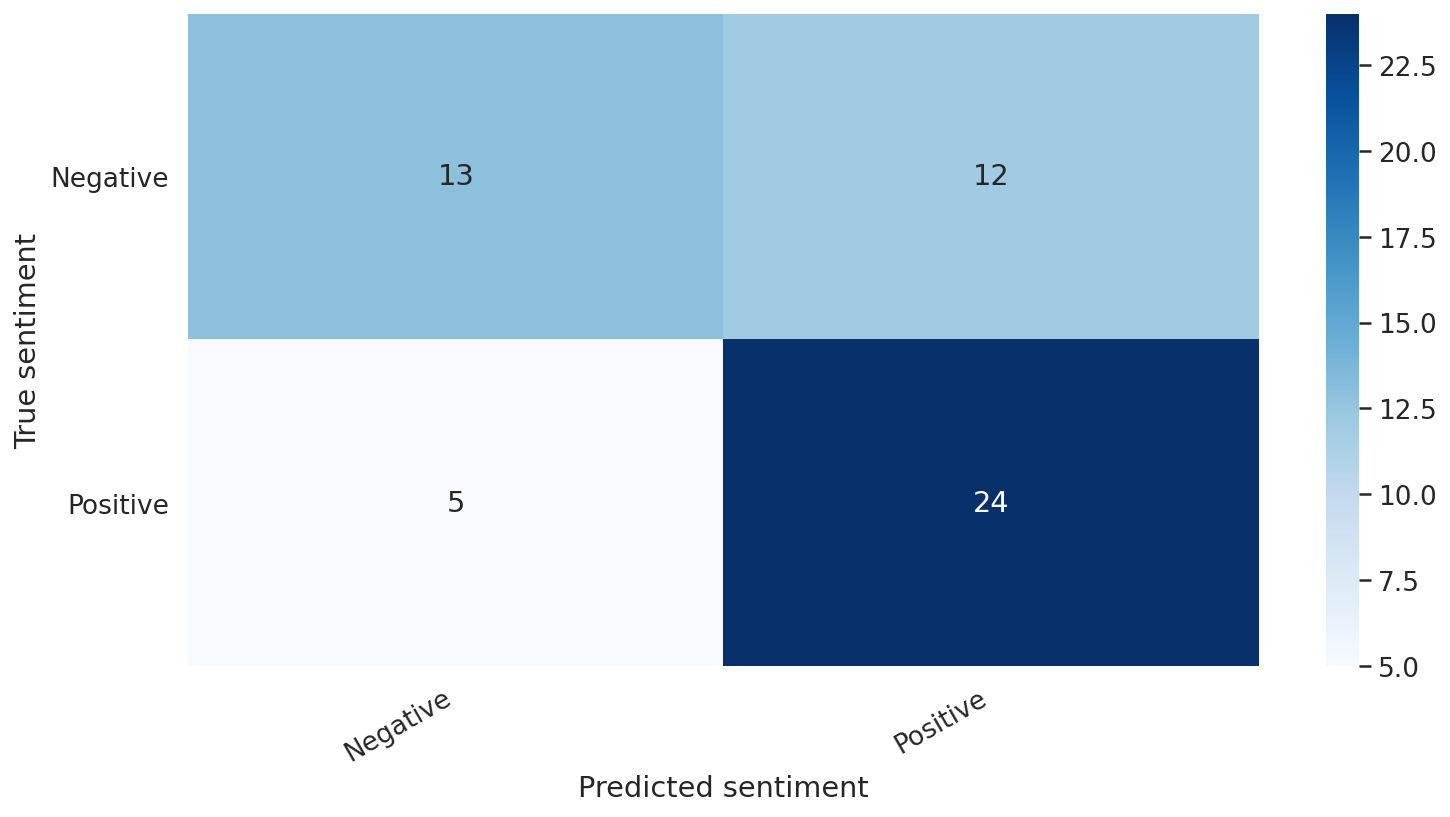

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

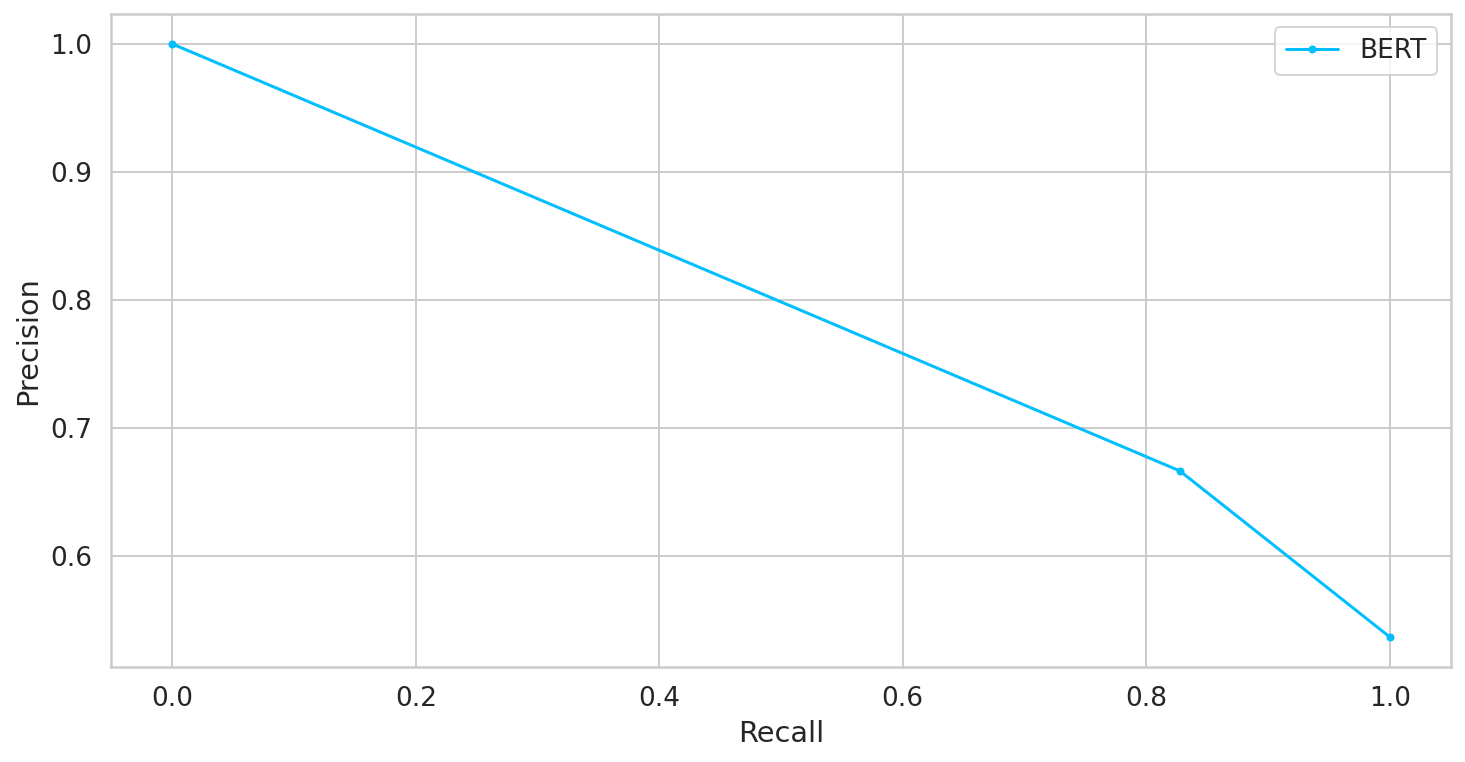

In [ ]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='BERT')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#Calculate AUC_score for PR curve
auc_score = auc(recall, precision)
print('PR AUC_score: %.3f' % auc_score)

PR AUC_score: 0.793


In [ ]:
#Inference scripting

In [ ]:
model = torch.load('model_210311.bin')

In [ ]:
counter = 0
wrong = []
for i in range(0,720):
    review_text , sentiment= df.text[i], df.Sentiment[i]
    
    MAX_LEN = 160
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    if class_names[int(sentiment)] != class_names[prediction]:
      counter += 1
      wrong.append(class_names[prediction])
      # print(review_text)
      # print('Ground truth :         ',class_names[int(sentiment)])
      # print('Predicted Sentiment  : ',class_names[prediction])
print(counter)
print(wrong)
print(wrong.count('Positive'), wrong.count('Negative'))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


27
['Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']
18 9


torch.Size([300, 30])
